In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from functions import plot_loss_curves
%load_ext autoreload
from func_job2 import *

In [2]:
cutout_dir = os.path.expandvars("$SCRATCH") + "/"
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"

In [3]:
hf = h5py.File(cutout_dir + "testing_create_cuts_noisy.h5", "r")
#hf= h5py.File(cutout_dir + "cutouts_filtered.h5", "r")

In [4]:
#get tile ids
tile_list = open(image_dir + "tiles.list", "r")

# Only use tiles with all five channels
tile_list = open(image_dir + "tiles.list", "r")
tile_ids = []

for tile in tile_list:
    tile = tile[:-1] # Remove new line character
    channels = tile.split(" ")
    if len(channels) == 5: # Order is u,g,r,i,z
        tile_ids.append(channels[0][5:12]) # XXX.XXX id
tile_list.close()

In [5]:
#need alternate method to get the tile ids because they don't follow the same order as before
tile_ids = list(hf.keys())


In [6]:
tile_ids

['134.283',
 '135.283',
 '136.282',
 '136.283',
 '137.282',
 '148.276',
 '149.275',
 '149.276',
 '150.274',
 '150.275',
 '150.276',
 '151.274',
 '153.272',
 '154.271',
 '157.269']

n_cutouts = 0
for i in range(5):
    print(i)
    n_cutouts += len(hf.get(tile_ids[i] + "/IMAGES"))
print(n_cutouts)


## Prep

### Lengths

In [7]:
n_cutouts = 0
for i in range(len(tile_ids)):
    print(i)
    n = len(hf.get(tile_ids[i] + "/IMAGES"))
    n_cutouts += n
    print(n)
print(n_cutouts)


0
818
1
16590
2
7884
3
23947
4
17315
5
617
6
4513
7
7452
8
239
9
6631
10
23947
11
2088
12
11
13
2497
14
688
115237


In [10]:
n_valid = len(hf.get(tile_ids[6] + "/IMAGES"))
print(n_valid)

25763


In [13]:
img = np.array(hf.get('180.272/IMAGES/c0'))

## Training hyperparams

In [9]:
# tiles for val and training
train_indices = range(5)
val_indices = [5]


#training on only one image
img = np.array(hf.get('180.272/IMAGES/c0'))
wgt = np.array(hf.get('180.272/WEIGHTS/c0'))

In [95]:
bands=1
r = np.stack( (img[...,2], wgt[...,2]), axis=-1)

In [11]:
BATCH_SIZE = 256
CUTOUT_SIZE = 64
N_EPOCHS = 2

## Functions

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint
# autosave best Model
model_checkpoint_file = "../Models/cfis_64p_nw.h5"
model_checkpoint_callback = ModelCheckpoint(model_checkpoint_file, monitor='loss', mode='min',verbose=1, save_best_only=True)


In [9]:
b = 0.001
bands=2
def flooded_MSE_with_uncertainty(y_true, y_pred): 
    weights = y_pred[...,bands:] 
    y_pred_image = y_pred[...,:bands]
    
    return tf.abs( K.square(tf.math.multiply((y_true - y_pred_image), weights)) - b ) + b

In [9]:
bands=2
def masked_MSE_with_uncertainty(y_true, y_pred): 
    weights = y_pred[...,bands:] 
    y_pred_image = y_pred[...,:bands]
    
    return K.square(tf.math.multiply((y_true - y_pred_image), weights ) )

## Compile model and train

In [105]:
#use np.stack instead of concat for 1 channel
xdata = np.stack((img[...,2], wgt[...,2]), axis = -1).reshape(1,64,64,bands*2)
ydata = img[...,2].reshape(1,64,64,bands)
plt.imshow(xdata[0,...,0])

In [92]:
# csv = pd.read_csv(cutout_dir + 'tiles_unbalanced.csv')
tile_ids = list(hf.keys())

In [49]:
%autoreload
autoencoder_cfis = create_autoencoder2((CUTOUT_SIZE, CUTOUT_SIZE, bands*2)) #last is the number of channels
#autoencoder_cfis = tf.keras.models.load_model("../Models/autoencoder_cfis_64p_r_nw2",
                                              #custom_objects={'masked_MSE_with_uncertainty': masked_MSE_with_uncertainty})
autoencoder_cfis.compile(optimizer="adam", loss=MSE_with_uncertainty)

In [15]:
autoencoder_cfis.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 4)]  0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [(None, 64, 64, 2)]  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 64, 64, 16)   304         tf_op_layer_strided_slice_3[0][0]
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 64, 64, 16)   64          conv2d_4[0][0]                   
_______________________________________________________________________________________

In [107]:
np.array(hf['134.283/IMAGES/c1'])[...,[0,2]].shape

(64, 64, 2)

In [108]:
%autoreload
(autoencoder_cfis, history_cfis) = func_job2.train_autoencoder(hf, tile_ids,
                                autoencoder_cfis, train_indices, val_indices, n_epochs= N_EPOCHS,
                              batch_size=BATCH_SIZE, cutout_size=CUTOUT_SIZE, bands ='cfis') 

Epoch 1/2
 34/259 [==>...........................] - ETA: 5:57 - loss: 2.1737e-04

KeyboardInterrupt: 

In [82]:
#saving model
autoencoder_cfis.save("../Models/autoencoder_cfis_64p")
hist_df = pd.DataFrame(history_cfis.history) 

hist_csv_file2 = '../Histories/history_cfis_64p.csv'
with open(hist_csv_file, mode='a') as f:
    hist_df.to_csv(f)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/autoencoder_cfis_64p/assets


NameError: name 'history_cfis' is not defined

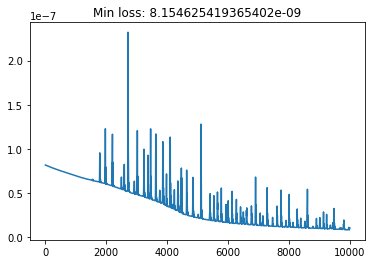

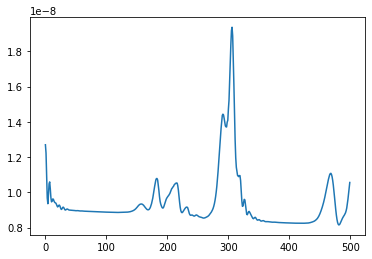

In [121]:
from functions import plot_loss_curves
#plot_loss_curves(history_cfis.history, figname="x.png")
plt.plot(history_cfis.history['loss'])
plt.title(f"Min loss: {np.min(history_cfis.history['loss'])}")
plt.show()
plt.plot(history_cfis.history['loss'][9500:])

In [122]:
og = xdata
decoded_imgs_cfis = autoencoder_cfis.predict(og)
residuals_cfis = og - decoded_imgs_cfis

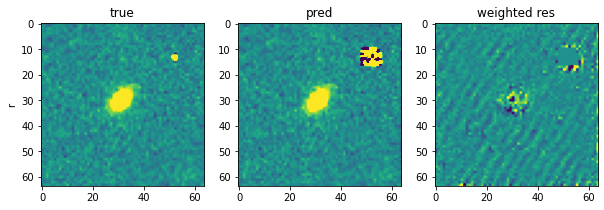

In [123]:
#bands = ['u','g','r', 'i', 'z']
bands = ['r']
fig,axes = plt.subplots(len(bands), 3, figsize =(10,3))
for i in range(len(bands)):
    norm_true  = ImageNormalize(og[0,...,i], interval=ZScaleInterval())
    norm_pred  = ImageNormalize(decoded_imgs_cfis[0,...,i], interval=ZScaleInterval())
            
    weighted_res = residuals_cfis[0,...,i]*og[0,...,i+1*len(bands)]
    norm_wres  = ImageNormalize( weighted_res, interval=ZScaleInterval())
            
    col1 = axes[0].imshow(og[0,...,i], norm = norm_true)
    col2 = axes[1].imshow(decoded_imgs_cfis[0,...,i], norm=norm_pred) 
    col3 = axes[2].imshow(weighted_res,norm = norm_wres)
    
    axes[0].set_ylabel(f'{bands[i]}')  
    
    if i == 0:
        axes[0].set_title('true')  
        axes[1].set_title('pred')  
        axes[2].set_title('weighted res')  
        

        

# Latent space rep using u-map

In [10]:
#autoencoder = keras.models.load_model("../Models/autoencoder_64p",
 #                                custom_objects={'custom_loss_all': custom_loss_all})
latent = keras.Model(autoencoder_cfis.input, autoencoder_cfis.layers[7].output)

In [12]:
test_index = 18
sources_test_cfis = get_test_cutouts(test_index, 50, CUTOUT_SIZE, "cfis")

In [13]:
decoded_imgs_cfis = latent.predict(sources_test_cfis)

In [14]:
decoded_imgs_cfis.shape

(50, 64, 64, 32)

In [15]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import umap.umap_ as umap
import seaborn as sns
from babyplots import Babyplot

In [16]:
#2d
reducer = umap.UMAP()
mapper =reducer.fit(decoded_imgs_cfis.reshape(50,64*64*32))
embedding = reducer.transform(decoded_imgs_cfis.reshape(50,64*64*32))

In [26]:
#3d
reducer3d = umap.UMAP(n_components = 3)
reducer3d.fit(decoded_imgs_cfis.reshape(50, 64*64*32))
embedding3d = reducer3d.transform(decoded_imgs_cfis.reshape(50,64*64*32))

In [24]:
img_list = np.linspace(1, 50, 50).tolist()

In [27]:
bp = Babyplot()
bp.add_plot(embedding3d.tolist(), "pointCloud",
           'categories', img_list,
           {'colorScale':'Set2',
            'ShowLegend' : True,
            'folded': True,
            'foldedEmbedding':embedding.tolist()})

<IPython.core.display.Javascript object>

In [28]:
bp

In [32]:
data_list = np.linspace(1, 50, 50).tolist()
data = decoded_imgs_cfis.reshape(50,64*64*32)
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data_list)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data_list)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data_list, s=100)
    plt.title(title, fontsize=18)

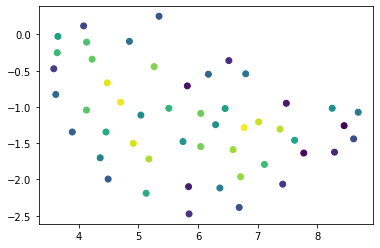

In [25]:
plt.scatter(embedding[:,0], embedding[:,1], c=img_list)

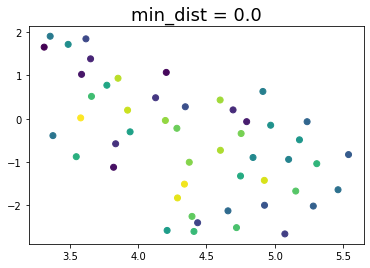

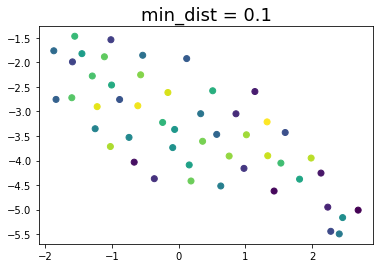

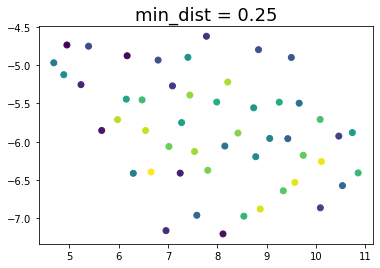

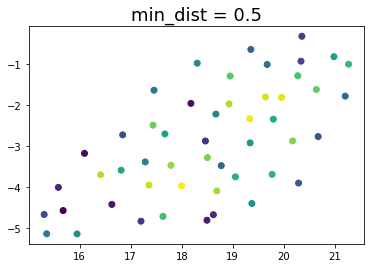

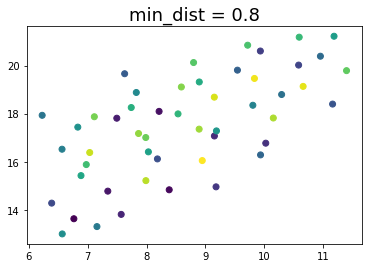

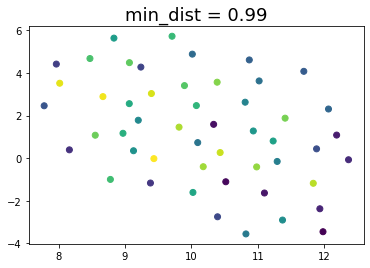

In [35]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

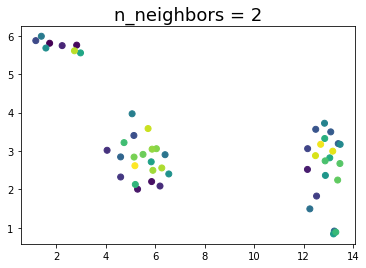

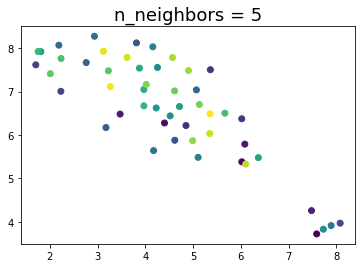

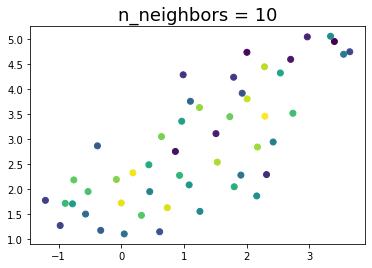

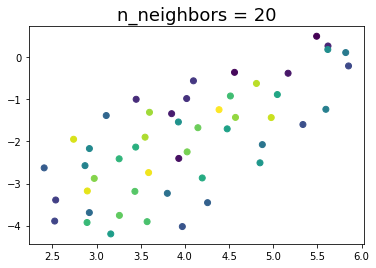

In [34]:
for n in (2, 5, 10, 20):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

## already trained

In [11]:
autoencoder_cfis = keras.models.load_model("../Models/job8.h5", custom_objects={'MSE_with_uncertainty': MSE_with_uncertainty})
#or
#autoencoder_cfis.load_weights("../Models/autoencoder_28tiles_50epochs.h5")
#hist_csv_file = '../Histories/history_cfis_128p.csv'

In [12]:
autoencoder_cfis

In [19]:
val_loss = [ 6.2421e-06,  1.6467e-05, 5.9857e-05, 3.4682e-05, 3.2534e-05, 2.2464e-05, 1.0210e-04, 7.5222e-06, 7.3666e-06,7.2582e-06, 7.1757e-06,7.0618e-06, 6.9292e-06,  6.8171e-06, 6.6931e-06, 6.5711e-06,6.4836e-06, 6.4199e-06, 6.3868e-06, 6.3454e-06, 6.3075e-06, 6.2706e-06, 6.2383e-06, 6.2083e-06, 6.1725e-06, 6.1389e-06, 6.1196e-06, 6.1132e-06, 6.1102e-06, 6.0996e-06, 6.0996e-06, 6.0921e-06, 6.0880e-06,6.1269e-06 ]
train_loss = [0.0212, 0.0158,  0.0059, 0.0418, 0.0216, 0.0212,  0.0102, 0.0236, 0.0236,  0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236,0.0236,0.0236,0.0236,0.0236,0.0236,0.0236,0.0236,0.0236,0.0236,0.0236]
epochs = range(34)

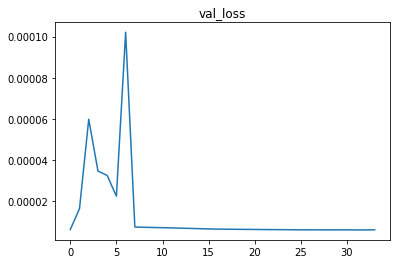

Text(0.5, 1.0, 'train_loss')

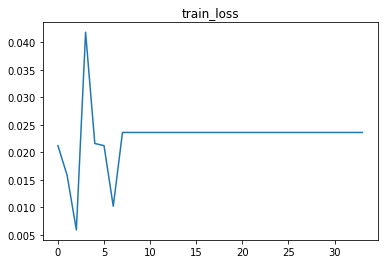

In [23]:
plt.plot(epochs, val_loss)
plt.title('val_loss')
plt.show()

plt.plot(epochs,train_loss)
plt.title('train_loss')

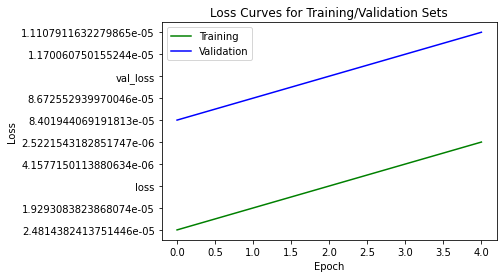

In [107]:
history_all = pd.read_csv(hist_csv_file)
plot_loss_curves(history_all, figname="trial1_a2_FiveTrainingTiles128p_copy.png")

# Test

In [44]:
def get_test_cutouts(index, n_cutouts, cutout_size, bands="cfis", start=0):
    n = 0
    if bands == "all":
        band_indices = [0, 1, 2, 3, 4]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
        
    elif bands == "cfis":
        band_indices = [0,2]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
    else: # PS1
        band_indices = [1, 3, 4]
        l = len(band_indices)
        sources = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        weights = np.zeros((n_cutouts, cutout_size, cutout_size, l))
        
    img_group = hf.get(tile_ids[index] + "/IMAGES")
    wt_group = hf.get(tile_ids[index] + "/WEIGHTS")
    for i in range(start+1, len(img_group)):
        sources[n,:,:,:] = np.array(img_group.get(f"c{i}"))[:,:,band_indices]
        weights[n,:,:,:] = np.array(wt_group.get(f"c{i}"))[:,:,band_indices]
        n += 1
        if n == n_cutouts:
            #return sources #if no weights
            return np.concatenate((sources, weights), axis=-1) #if we train with weights

In [50]:
test_index = 2
sources_test_cfis = get_test_cutouts(test_index, 20, CUTOUT_SIZE, "cfis")
sources_test_cfis.shape

(20, 64, 64, 4)

In [51]:
decoded_imgs_cfis = autoencoder_cfis.predict(sources_test_cfis)
residuals_cfis = sources_test_cfis - decoded_imgs_cfis

In [63]:
def plot_images(images_true, images_pred, images_res, bands, figname):
    n = len(bands)
    fig,axes = plt.subplots(images_true.shape[0], len(bands)*n*2, figsize =(40,125))
    plt.setp(axes, xticks=[], yticks=[])
    
    for img in range(images_true.shape[0]):
        for bd in range(len(bands)):
            norm_true  = ImageNormalize(images_true[img,:,:,bd], interval=ZScaleInterval())
            norm_pred  = ImageNormalize(images_pred[img,:,:,bd], interval=ZScaleInterval())
            
            weighted_res = images_res[img,:,:,bd]*images_true[img,:,:,bd+1*n]
            norm_wres  = ImageNormalize( weighted_res, interval=ZScaleInterval())
            
            imw = axes[img][bd].imshow(images_true[img,:,:,bd+1*n])
            im1 = axes[img][bd+1*n].imshow(images_true[img,:,:,bd], norm = norm_true)
            im2 = axes[img][bd+2*n].imshow(images_pred[img,:,:,bd], norm = norm_pred)
            im3 = axes[img][bd+3*n].imshow(weighted_res, norm = norm_wres)

            if img == 0:
                axes[img][bd].set_title(bands[bd])                
                axes[img][bd].set_title(bands[bd])
                axes[img][bd+1*n].set_title(bands[bd])                
                axes[img][bd+1*n].set_title(bands[bd])
                axes[img][bd+2*n].set_title(bands[bd])                
                axes[img][bd+2*n].set_title(bands[bd])
                axes[img][bd+3*n].set_title(bands[bd])                
                axes[img][bd+3*n].set_title(bands[bd])
    #plt.savefig("../Plots/" + figname)

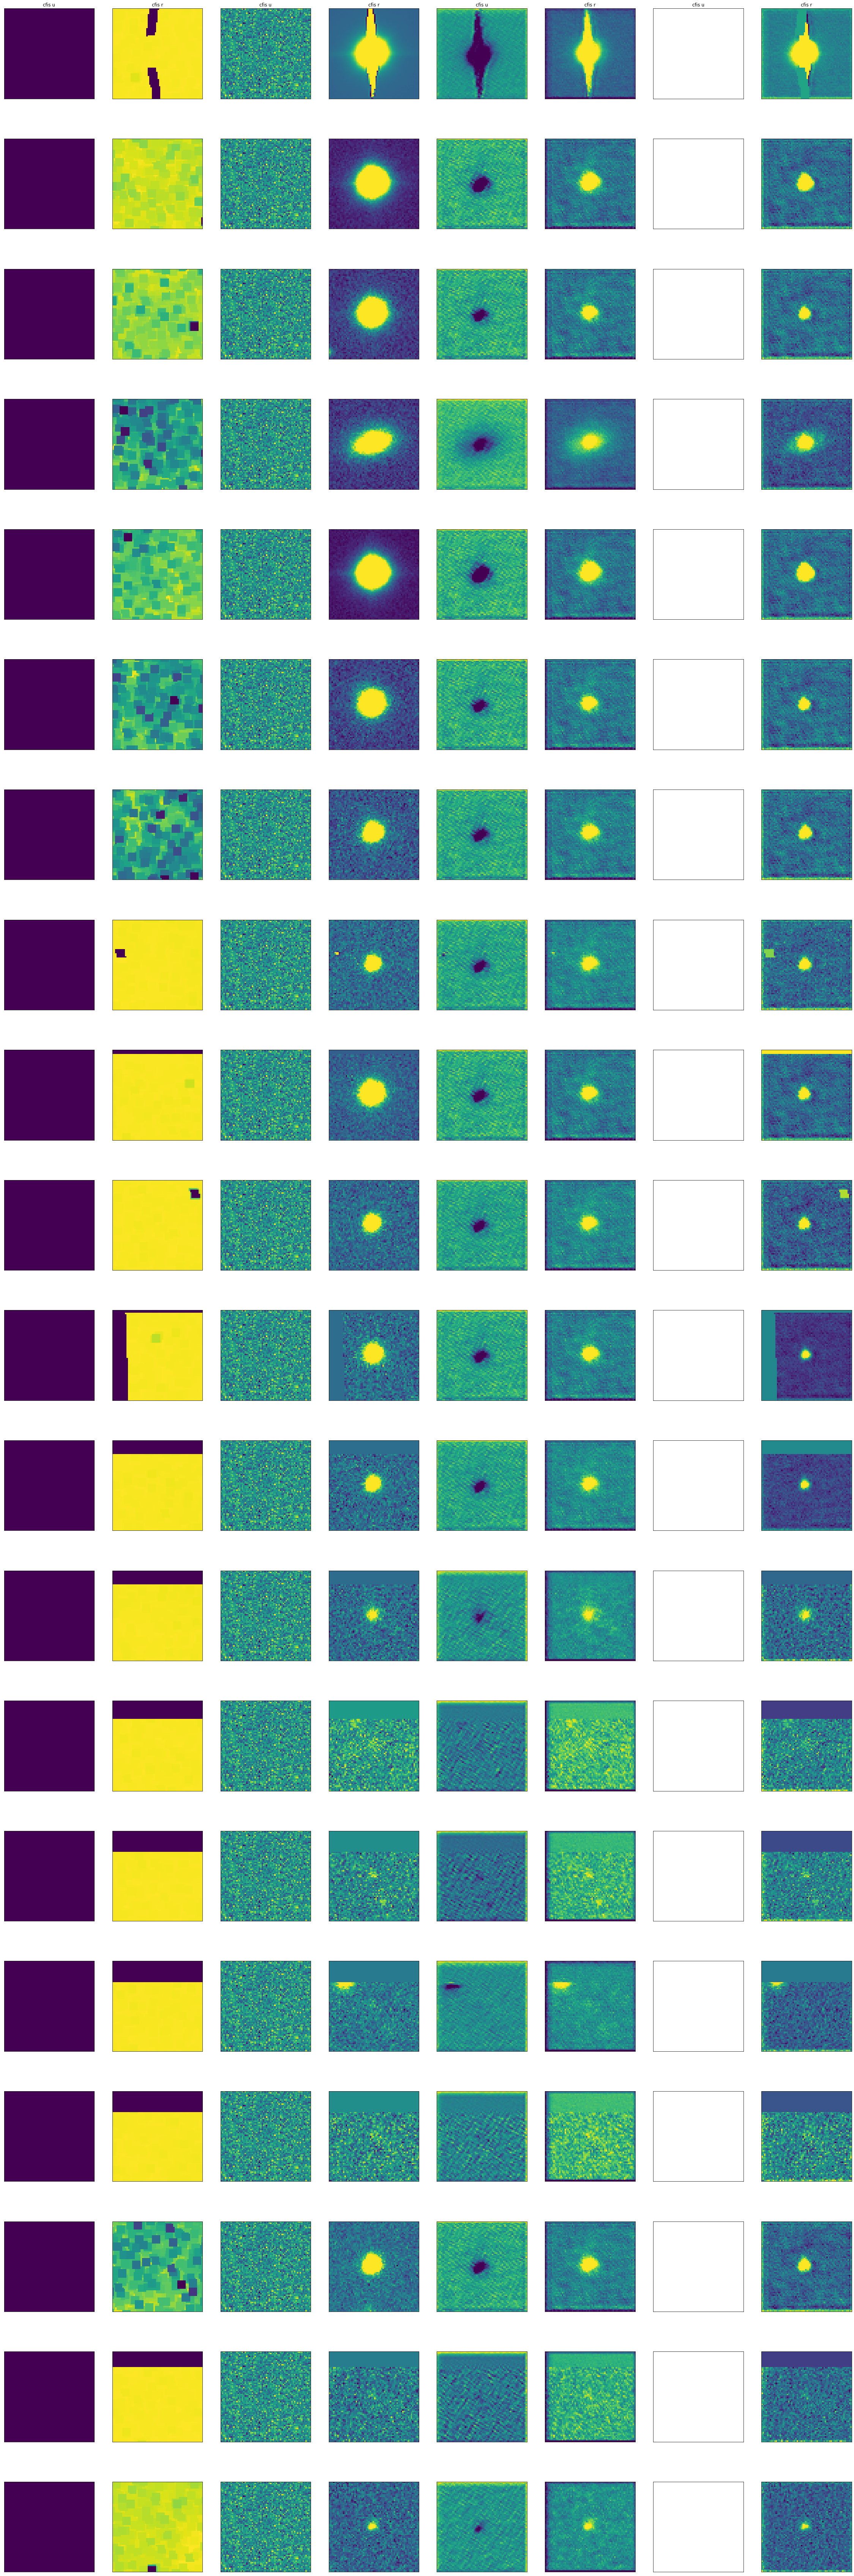

In [64]:
bands = ['cfis u', 'cfis r']
plot_images(sources_test_cfis[...], decoded_imgs_cfis[...], residuals_cfis[...],bands, figname = 'x')